#  <center> Speech Emotion Recognition <center>

![IMAGE](https://cainvas-static.s3.amazonaws.com/media/user_data/arya.ashish/SER.gif)

#### Speech Emotion Recognition is the task of recognizing emotion on the basis of your speech.It has uses in application in song recommendation on the basis of your mood and it has various other applications as well in which mood of a person plays a vital role.

## Importing the Dataset and Trained Model
#### This notebook contains the training part as well but if anyone wants to skip training and access performance of the model,you can use the model trained by me.
#### You can run the command and this will load the model to your workspace
- !wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/arya.ashish/SERmodel.h5"

In [ ]:
# This will load the dataset.You will see a folder called ALL in your workspace.
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/arya.ashish/SER.zip"
!unzip -o SER.zip 
!rm SER.zip

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import tensorflow as tf
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization ,Activation
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Data Preparation
#### Creating a Dataframe for the Dataset.

In [2]:
Savee = "ALL/"

In [3]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
data_path = pd.concat([emotion_df, path_df], axis=1)
data_path.head()

Emotions             Path
0      fear   ALL/DC_f07.wav
1   disgust   ALL/DC_d13.wav
2      fear   ALL/JE_f05.wav
3       sad  ALL/KL_sa15.wav
4  surprise  ALL/JK_su03.wav

## Data Visualisation and Exploration

First let's plot the count of each emotions in our dataset.

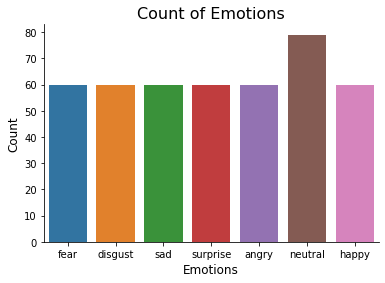

In [4]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

We can also plot waveplots and spectograms for audio signals

* Waveplots - Waveplots let us know the loudness of the audio at a given time.
* Spectograms - A spectrogram is a visual representation of the spectrum of frequencies of sound or other signals as they vary with time. It’s a representation of frequencies changing with respect to time for given audio/music signals.

In [5]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

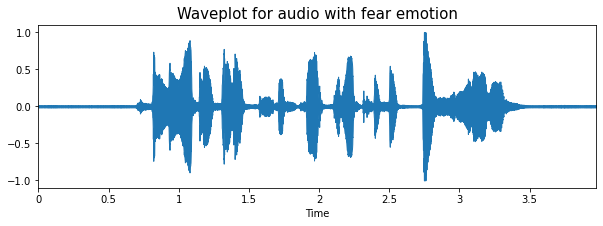

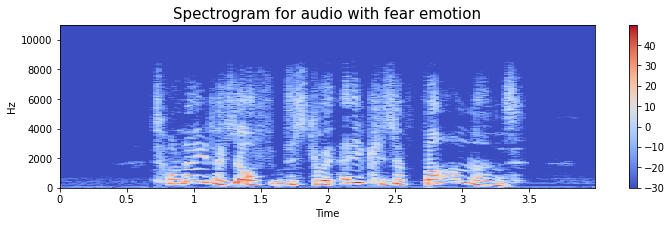

In [6]:
emotion='fear'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

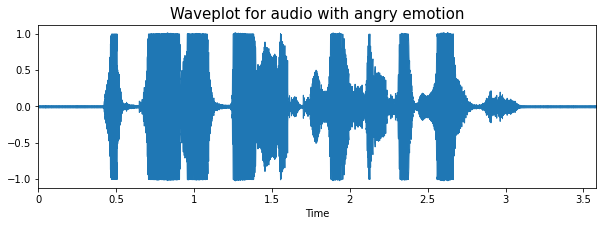

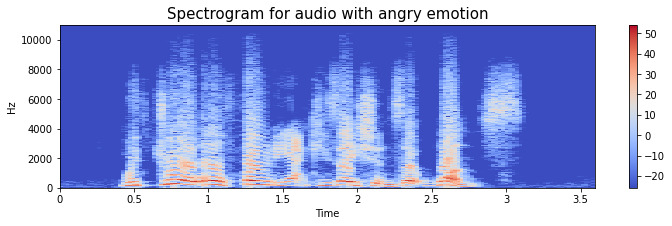

In [7]:
emotion='angry'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

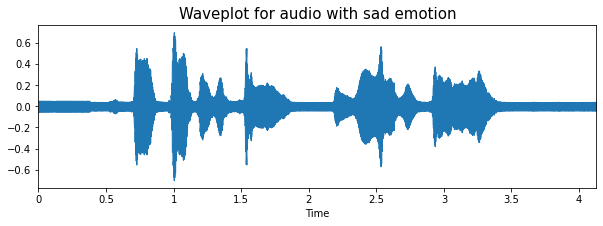

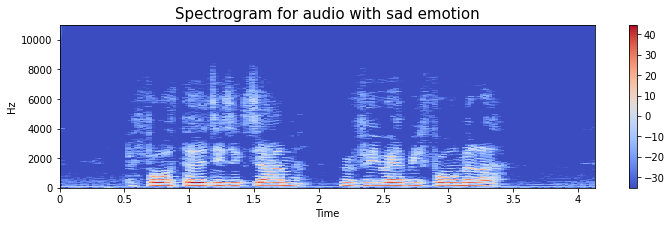

In [8]:
emotion='sad'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

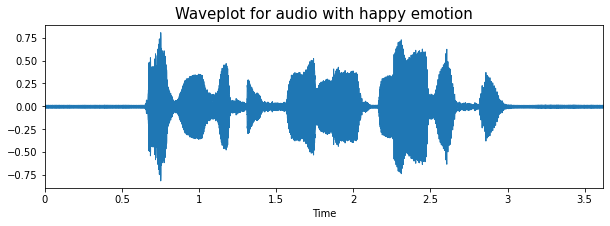

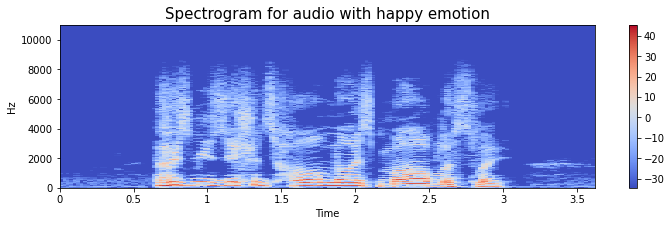

In [9]:
emotion='happy'
path = np.array(data_path.Path[data_path.Emotions==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

## Data Augmentation

- We will apply some data augmentation such as introduction of some noise or stretching the audio signals etc, for better training results

In [10]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

#### 1. Simple Audio

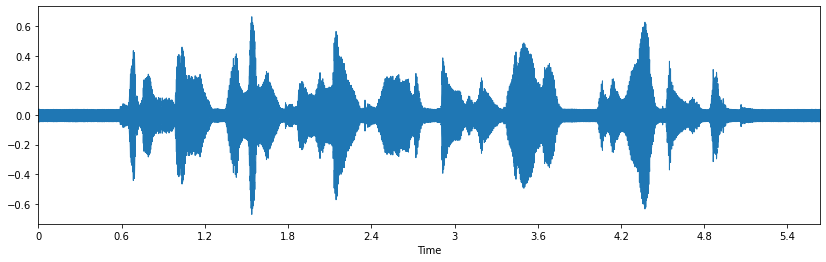

In [11]:
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=data, sr=sample_rate)
Audio(path)

#### 2. Noise Injection

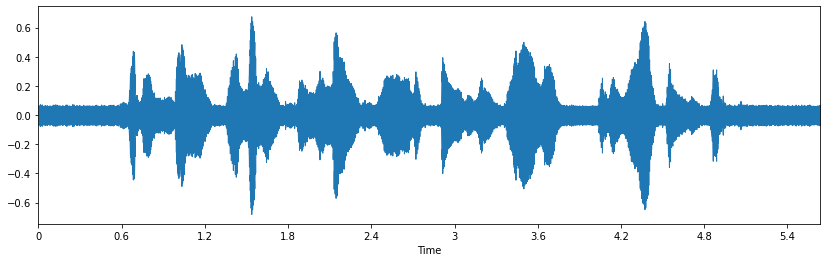

In [12]:
x = noise(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

We can see noise injection is a very good augmentation technique because of which we can assure our training model is not overfitted

#### 3. Stretching

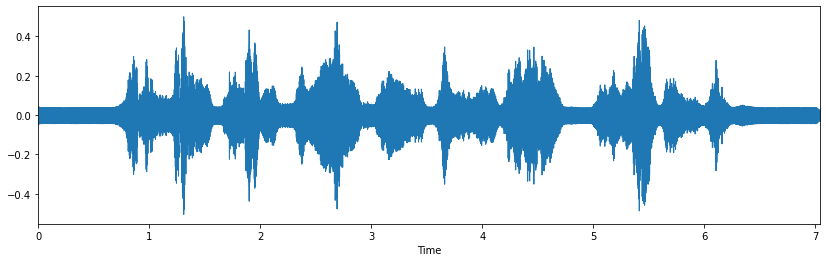

In [13]:
x = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 4. Shifting

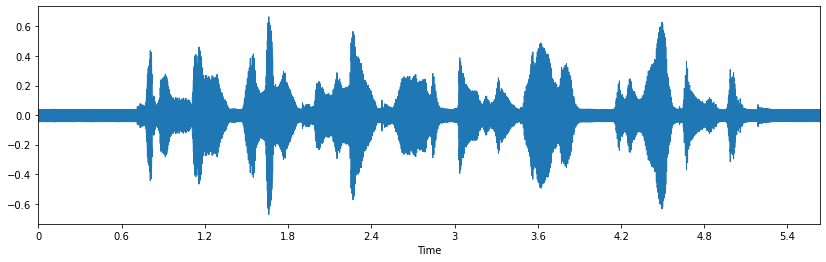

In [14]:
x = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

#### 5. Pitch

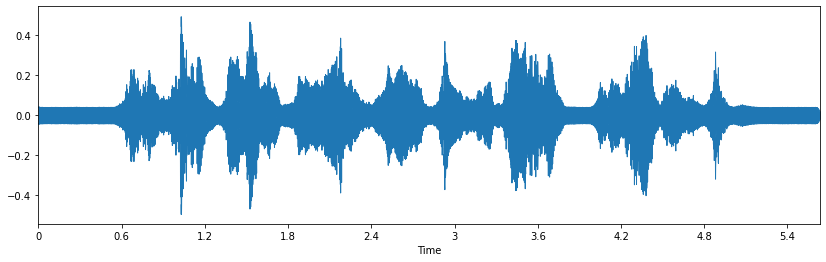

In [15]:
x = pitch(data, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveplot(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

- From the above types of augmentation techniques i am using noise, stretching(ie. changing speed) and some pitching.

## Feature Extraction
- Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.

In this project i am not going deep in feature selection process to check which features are good for our dataset rather i am only extracting 5 audio features:
- Zero Crossing Rate
- Chroma_stft
- MFCC
- RMS(root mean square) value
- MelSpectogram to train our model.

In [16]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [17]:
# Extracting features and performing augmentations
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [18]:
len(X), len(Y), data_path.Path.shape

(1317, 1317, (439,))

In [19]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3         4         5         6  \
0  0.023844  0.376802  0.544572  0.515236  0.393183  0.371867  0.482094   
1  0.040211  0.491715  0.645685  0.633805  0.517121  0.491005  0.548396   
2  0.027655  0.288429  0.300280  0.476859  0.604356  0.408313  0.317014   
3  0.025920  0.468795  0.591989  0.610804  0.533011  0.498842  0.457363   
4  0.090016  0.651505  0.701066  0.676727  0.641132  0.618910  0.554807   

          7         8         9  ...           153           154  \
0  0.712659  0.718695  0.479259  ...  4.097942e-06  9.281065e-07   
1  0.754062  0.745910  0.562402  ...  1.446818e-02  1.348010e-02   
2  0.379047  0.622897  0.778989  ...  5.480809e-06  2.006418e-06   
3  0.418604  0.356388  0.357391  ...  3.380302e-07  2.274208e-07   
4  0.497555  0.484047  0.527756  ...  3.098961e-02  3.182451e-02   

            155           156           157           158           159  \
0  2.970960e-07  2.264097e-07  2.703385e-07  3.726052e-07  5.253090e-07   
1  1.422179e-02  1.435243e-02  1.494704e-02  1.374198e-02  1.472634e-02   
2  9.367810e-07  7.464228e-07  7.515688e-07  8.350502e-07  1.116672e-06   
3  1.679705e-07  1.774402e-07  2.407547e-07  3.790489e-07  6.543595e-07   
4  3.369049e-02  2.998350e-02  3.167661e-02  3.109721e-02  3.311347e-02   

            160           161   labels  
0  7.502915e-07  8.361687e-07     fear  
1  1.424875e-02  1.427160e-02     fear  
2  1.503249e-06  1.655530e-06     fear  
3  9.678180e-07  1.121691e-06  disgust  
4  3.242827e-02  3.251858e-02  disgust  

[5 rows x 163 columns]

## Data Preparation

- As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [19]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [20]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [21]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((987, 162), (987, 7), (330, 162), (330, 7))

In [22]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((987, 162), (987, 7), (330, 162), (330, 7))

In [23]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((987, 162, 1), (987, 7), (330, 162, 1), (330, 7))

## Model Architecture

In [28]:
# building the model:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',activation = 'relu',input_shape=(x_train.shape[1],1)))  
model.add(Conv1D(256, 8, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same', activation='relu'))
model.add(Conv1D(128, 8, padding='same', activation='relu'))
model.add(Dropout(0.4))
model.add(Conv1D(128, 8, padding='same', activation='relu'))
model.add(Conv1D(128, 8, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same', activation='relu'))
model.add(Conv1D(64, 8, padding='same', activation='relu'))
model.add(Flatten())
model.add(Dense(7, activation='softmax')) 
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer= opt ,loss='categorical_crossentropy',metrics=['acc'])

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 162, 256)          2304      
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 162, 256)          524544    
_________________________________________________________________
batch_normalization_4 (Batch (None, 162, 256)          1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 162, 256)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 20, 256)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 20, 128)           262272    
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 20, 128)          

# Creating checkpoint for Model Training

In [29]:
checkpointer = ModelCheckpoint('new_model.h5', monitor='val_acc', mode='max', verbose=2, save_best_only=True)
history=model.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[checkpointer])

Epoch 1/100
16/16 [==============================] - ETA: 0s - loss: 1.9354 - acc: 0.1895
Epoch 00001: val_acc improved from -inf to 0.18182, saving model to new_model.h5
16/16 [==============================] - 24s 1s/step - loss: 1.9354 - acc: 0.1895 - val_loss: 1.9105 - val_acc: 0.1818
Epoch 2/100
16/16 [==============================] - ETA: 0s - loss: 1.8026 - acc: 0.2725
Epoch 00002: val_acc improved from 0.18182 to 0.24848, saving model to new_model.h5
16/16 [==============================] - 24s 1s/step - loss: 1.8026 - acc: 0.2725 - val_loss: 1.8499 - val_acc: 0.2485
Epoch 3/100
16/16 [==============================] - ETA: 0s - loss: 1.7067 - acc: 0.2715
Epoch 00003: val_acc improved from 0.24848 to 0.26364, saving model to new_model.h5
16/16 [==============================] - 24s 1s/step - loss: 1.7067 - acc: 0.2715 - val_loss: 1.8147 - val_acc: 0.2636
Epoch 4/100
16/16 [==============================] - ETA: 0s - loss: 1.5914 - acc: 0.2948
Epoch 00004: val_acc did not impro

# Loading the model which we trained just now

In [30]:
present_model = tf.keras.models.load_model('new_model.h5')
present_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_16 (Conv1D)           (None, 162, 256)          2304      
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 162, 256)          524544    
_________________________________________________________________
batch_normalization_4 (Batch (None, 162, 256)          1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 162, 256)          0         
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 20, 256)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 20, 128)           262272    
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 20, 128)          

# Getting the accuracy of the model that we trained.

In [31]:
print("Accuracy of our model on test data : " , present_model.evaluate(x_test,y_test)[1]*100 , "%")

11/11 [==============================] - 2s 170ms/step - loss: 1.0404 - acc: 0.7545
Accuracy of our model on test data :  75.45454502105713 %


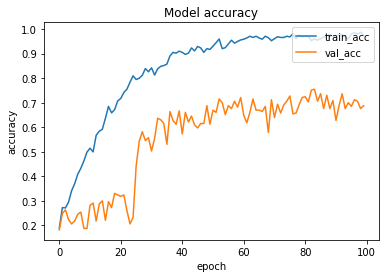

In [34]:
# plot the training artifacts

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_acc','val_acc'], loc = 'upper right')
plt.show()

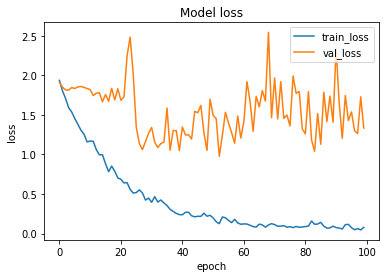

In [35]:
# plot the training artifacts

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.show()

# Accessing the Model's Performance

In [36]:
# predicting on test data.
pred_test = present_model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [37]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels Actual Labels
0          disgust       disgust
1          neutral       neutral
2          neutral       neutral
3          neutral       neutral
4         surprise         happy
5          neutral       neutral
6             fear          fear
7             fear          fear
8            happy         happy
9          disgust       disgust

In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.76      0.83      0.80        42
     disgust       0.62      0.76      0.68        51
        fear       0.96      0.57      0.71        46
       happy       0.59      0.72      0.65        40
     neutral       0.88      0.79      0.83        63
         sad       0.90      0.88      0.89        42
    surprise       0.70      0.72      0.71        46

    accuracy                           0.75       330
   macro avg       0.77      0.75      0.75       330
weighted avg       0.78      0.75      0.76       330



- As we can see that the model attained 75% test accuracy.Now we will load my trained model which has been trained on a larger dataset and for larger number of epochs.If you want you can also skip this step.

In [ ]:
!wget -N "https://cainvas-static.s3.amazonaws.com/media/user_data/arya.ashish/SERmodel.h5"

In [32]:
pre_trained_model = tf.keras.models.load_model('SERmodel.h5')
pre_trained_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 162, 256)          2304      
_________________________________________________________________
activation (Activation)      (None, 162, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 162, 256)          524544    
_________________________________________________________________
batch_normalization (BatchNo (None, 162, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 162, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 162, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 256)          

### As we can see that my pretrained model is attaining 92% test accuracy

In [33]:
print("Accuracy of our model on test data : " , pre_trained_model.evaluate(x_test,y_test)[1]*100 , "%")

11/11 [==============================] - 2s 168ms/step - loss: 0.2702 - acc: 0.9273
Accuracy of our model on test data :  92.72727370262146 %


# Compiling the model with DeepC

In [39]:
!deepCC new_model.h5

reading [keras model] from 'new_model.h5'

[ERROR] : 2020-10-21 03:58:24.754944: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory
2020-10-21 03:58:24.755053: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2020-10-21 03:58:28.390062: W tensorflow/stream_executor/platform/default/dso_loader.cc:59] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2020-10-21 03:58:28.390169: W tensorflow/stream_executor/cuda/cuda_driver.cc:312] failed call to cuInit: UNKNOWN ERROR (303)
2020-10-21 03:58:28.390239: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-20-156): /proc/driver/nvidia/version does not exist
2020-10